In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet import Unet
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_pixel_accuracy
from train_utils import Trainer, he_init

2024-12-17 14:18:13.070015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734425293.087515   22313 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734425293.092968   22313 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:18:13.110516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load config.
with open('../configs/train_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load dataset.
transform = transforms.Compose([
    transforms.ToTensor()
])
DATA_DIR = '/home/kramasamy/Code/projects/cnn/data/isbi_em_segmentation'
train_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=True)
test_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=False)

In [3]:
##Load model.
# Get dataset class frequency. 

In [4]:
# Load model.
model = Unet()
model.to('cuda')
model.apply(he_init)
trainer = Trainer(model, train_dataset, config)
result = trainer.train(print_loss=True)

tensor([0.7795, 0.2205])
Get loss fn with weighted loss.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 10.868305737773577


  5%|▌         | 1/20 [02:11<41:39, 131.54s/it]

Epoch 2/20, Loss: 0.6106079076727231


 10%|█         | 2/20 [05:27<50:46, 169.26s/it]

Epoch 3/20, Loss: 0.4518926486372948


 15%|█▌        | 3/20 [09:25<56:50, 200.59s/it]

Epoch 4/20, Loss: 0.397968756655852


 20%|██        | 4/20 [12:06<49:21, 185.06s/it]

Epoch 5/20, Loss: 0.3818986892700195


 25%|██▌       | 5/20 [14:23<41:57, 167.81s/it]

Epoch 6/20, Loss: 0.36302522917588553


 30%|███       | 6/20 [16:41<36:48, 157.72s/it]

Epoch 7/20, Loss: 0.35172927329937614


 35%|███▌      | 7/20 [18:59<32:46, 151.28s/it]

Epoch 8/20, Loss: 0.3434472973148028


 40%|████      | 8/20 [21:16<29:21, 146.79s/it]

Epoch 9/20, Loss: 0.33693039963642757


 45%|████▌     | 9/20 [23:34<26:22, 143.90s/it]

Epoch 10/20, Loss: 0.3277759050329526


 50%|█████     | 10/20 [25:52<23:40, 142.08s/it]

Epoch 11/20, Loss: 0.32324778139591215


 55%|█████▌    | 11/20 [28:10<21:07, 140.84s/it]

Epoch 12/20, Loss: 0.32536896616220473


 60%|██████    | 12/20 [30:28<18:40, 140.10s/it]

Epoch 13/20, Loss: 0.309900309642156


 65%|██████▌   | 13/20 [32:47<16:16, 139.52s/it]

Epoch 14/20, Loss: 0.3044992690285047


 70%|███████   | 14/20 [35:05<13:54, 139.13s/it]

Epoch 15/20, Loss: 0.30734227448701856


 75%|███████▌  | 15/20 [37:24<11:35, 139.04s/it]

Epoch 16/20, Loss: 0.30241797069708504


 80%|████████  | 16/20 [39:46<09:20, 140.07s/it]

Epoch 17/20, Loss: 0.2953794280687968


 85%|████████▌ | 17/20 [42:12<07:05, 141.92s/it]

Epoch 18/20, Loss: 0.2929431214928627


 90%|█████████ | 18/20 [44:39<04:46, 143.37s/it]

Epoch 19/20, Loss: 0.29079517076412836


 95%|█████████▌| 19/20 [47:06<02:24, 144.35s/it]

Epoch 20/20, Loss: 0.28569041987260185


100%|██████████| 20/20 [49:34<00:00, 148.70s/it]


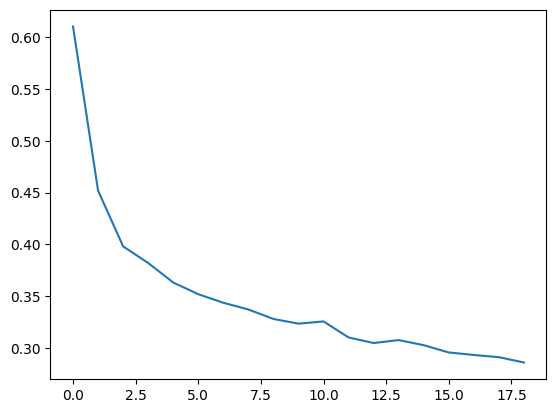

In [5]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [6]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [7]:
print(get_pixel_accuracy(y_pred_train, y_true_train))
print(get_pixel_accuracy(y_pred_test, y_true_test))


86.63349151611328
87.11270141601562


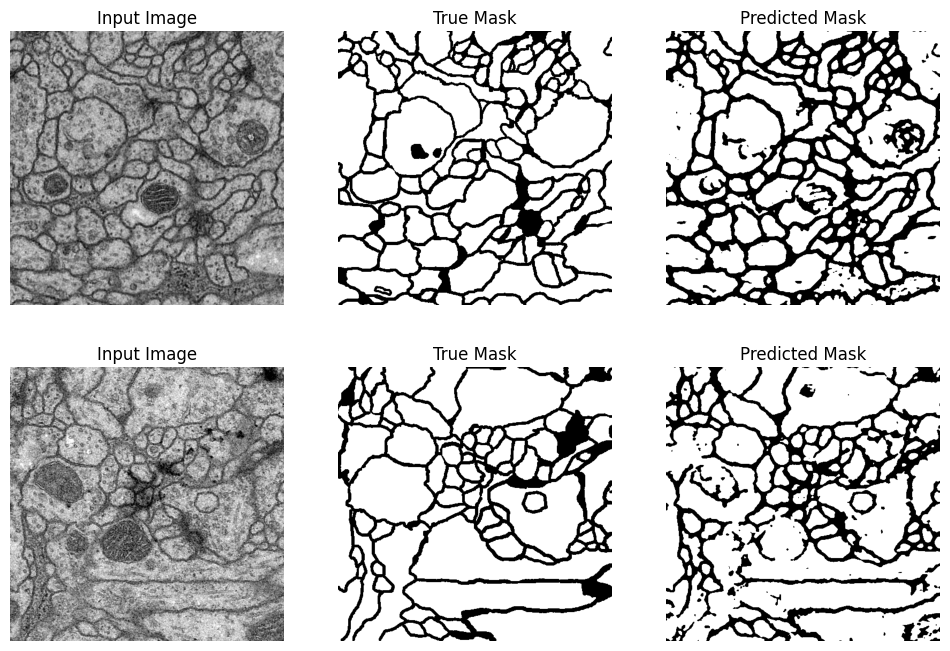

In [10]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset

n = 2 # Number to sample to examine.

random_indices = random.sample(range(len(test_dataset)), n)
random_subset = Subset(train_dataset, random_indices)
random_test_dataloader = DataLoader(random_subset, batch_size=2)
y_pred_logits, y_true = evaluate_model(model, random_test_dataloader)


fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    img = random_subset[i][0]
    # Plot input image (assuming the image has 3 channels or grayscale)
    axes[i, 0].imshow(img.squeeze().to('cpu'), cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # Plot true mask
    axes[i, 1].imshow(y_true[i].to('cpu'), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    # Plot predicted mask
    y_probs = F.softmax(y_pred_logits[i], dim=0)
    y_pred = torch.argmax(y_probs, dim=0)
    axes[i, 2].imshow(y_pred.to('cpu'), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')